<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/Course%202%20-%20Part%202%20-%20Lesson%202%20-%20Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

In [6]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Transfer learning for image detection using inceptio

1.   Explore the Example Data of Cats, Dogs, family and nature photos
2.   Build and Train a Neural Network to recognize the difference between them
3.   Evaluate the Training and Validation accuracy
4.   Predict whether the a picture is one of them.

## Explore the Example Data

Let's start by downloading our example data, a .zip of 2,000 JPG pictures of cats and dogs, and extracting it locally in `/tmp`.

**NOTE:** The 2,000 images used in this exercise are excerpted from the ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) available on Kaggle, which contains 25,000 images. Here, we use a subset of the full dataset to decrease training time for educational purposes. Also we use the family photo for the purposes of human and nature.

In [7]:
# Import varius tensor flow and other functions.
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
import os
import zipfile
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

The following python code will use the OS library to use Operating System libraries, giving you access to the file system, and the zipfile library allowing you to unzip the data. 

The contents of the .zip are extracted to the base directory `/tmp/cats_and_dogs_filtered`, which contains `train` and `validation` subdirectories for the training and validation datasets (see the [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/validation/check-your-intuition) for a refresher on training, validation, and test sets), which in turn each contain `cats` and `dogs` subdirectories.

In short: The training set is the data that is used to tell the neural network model that 'this is what a cat looks like', 'this is what a dog looks like' etc. The validation data set is images of cats and dogs that the neural network will not see as part of the training, so you can test how well or how badly it does in evaluating if an image contains a cat or a dog.

One thing to pay attention to in this sample: We do not explicitly label the images as cats or dogs. If you remember with the handwriting example earlier, we had labelled 'this is a 1', 'this is a 7' etc.  Later you'll see something called an ImageGenerator being used -- and this is coded to read images from subdirectories, and automatically label them from the name of that subdirectory. So, for example, you will have a 'training' directory containing a 'cats' directory and a 'dogs' one. ImageGenerator will label the images appropriately for you, reducing a coding step. 

Let's define each of these directories:

In [8]:
base_dir = 'C:/Users/sethr/education/Healthcare/imagedetect'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
predict_dir=os.path.join(base_dir, 'predict')

# Directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
train_human_dir = os.path.join(train_dir, 'human')
train_other_dir = os.path.join(train_dir, 'other')
# Directory with our validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
validation_human_dir = os.path.join(validation_dir, 'human')
validation_other_dir = os.path.join(validation_dir, 'other')

Now, let's see what the filenames look like in the `cats` and `dogs` `train` directories (file naming conventions are the same in the `validation` directory):

In [9]:
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )
train_human_fnames = os.listdir( train_human_dir )
train_other_fnames = os.listdir( train_other_dir )

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])
print(train_human_fnames[:20])
print(train_other_fnames[:10])


['cat.10.jpg', 'cat.100.jpg', 'cat.101.jpg', 'cat.102.jpg', 'cat.103.jpg', 'cat.104.jpg', 'cat.105.jpg', 'cat.106.jpg', 'cat.107.jpg', 'cat.108.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg', 'dog.107.jpg']
['dear1.jpg', 'dear10.jpg', 'dear1000.jpg', 'dear1001.jpg', 'dear1002.jpg', 'dear1003.jpg', 'dear1004.jpg', 'dear1005.jpg', 'dear1006.jpg', 'dear1007.jpg', 'dear1008.jpg', 'dear1009.jpg', 'dear1010.jpg', 'dear1011.jpg', 'dear1012.jpg', 'dear103.jpg', 'dear104.jpg', 'dear105.jpg', 'dear106.jpg', 'dear107.jpg']
['other1.jpg', 'other10.jpg', 'other100.jpg', 'other1000.jpg', 'other1001.jpg', 'other1002.jpg', 'other1003.jpg', 'other1004.jpg', 'other1005.jpg', 'other1006.jpg']


Let's find out the total number of cat and dog images in the `train` and `validation` directories:

In [10]:
print('total training cat images :', len(os.listdir(      train_cats_dir ) ))
print('total training dog images :', len(os.listdir(      train_dogs_dir ) ))
print('total training human images:', len(os.listdir(      train_human_dir )))
print('total training other images:', len(os.listdir(      train_other_dir ) ))
print('total validation cat images :', len(os.listdir( validation_cats_dir ) ))
print('total validation dog images :', len(os.listdir( validation_dogs_dir ) ))
print('total validation human images :', len(os.listdir( validation_human_dir ) ))
print('total validation other images :', len(os.listdir( validation_other_dir ) ))
print('total test images:',len(os.listdir(predict_dir)))

total training cat images : 990
total training dog images : 982
total training human images: 1682
total training other images: 1449
total validation cat images : 500
total validation dog images : 500
total validation human images : 766
total validation other images : 371
total test images: 69


For both cats and dogs, we have 1,000 training images and 500 validation images. Human and others add up to ~10,000 pictures.

Now let's take a look at a few pictures to get a better sense of what the cat and dog datasets look like. First, configure the matplot parameters:

In [11]:
%matplotlib inline

#import matplotlib.image as mpimg
# import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 8
ncols = 4

pic_index = 0 # Index for iterating over images

Now, display a batch of 8 cat,dog,human and other pictures. You can rerun the cell to see a fresh batch each time:

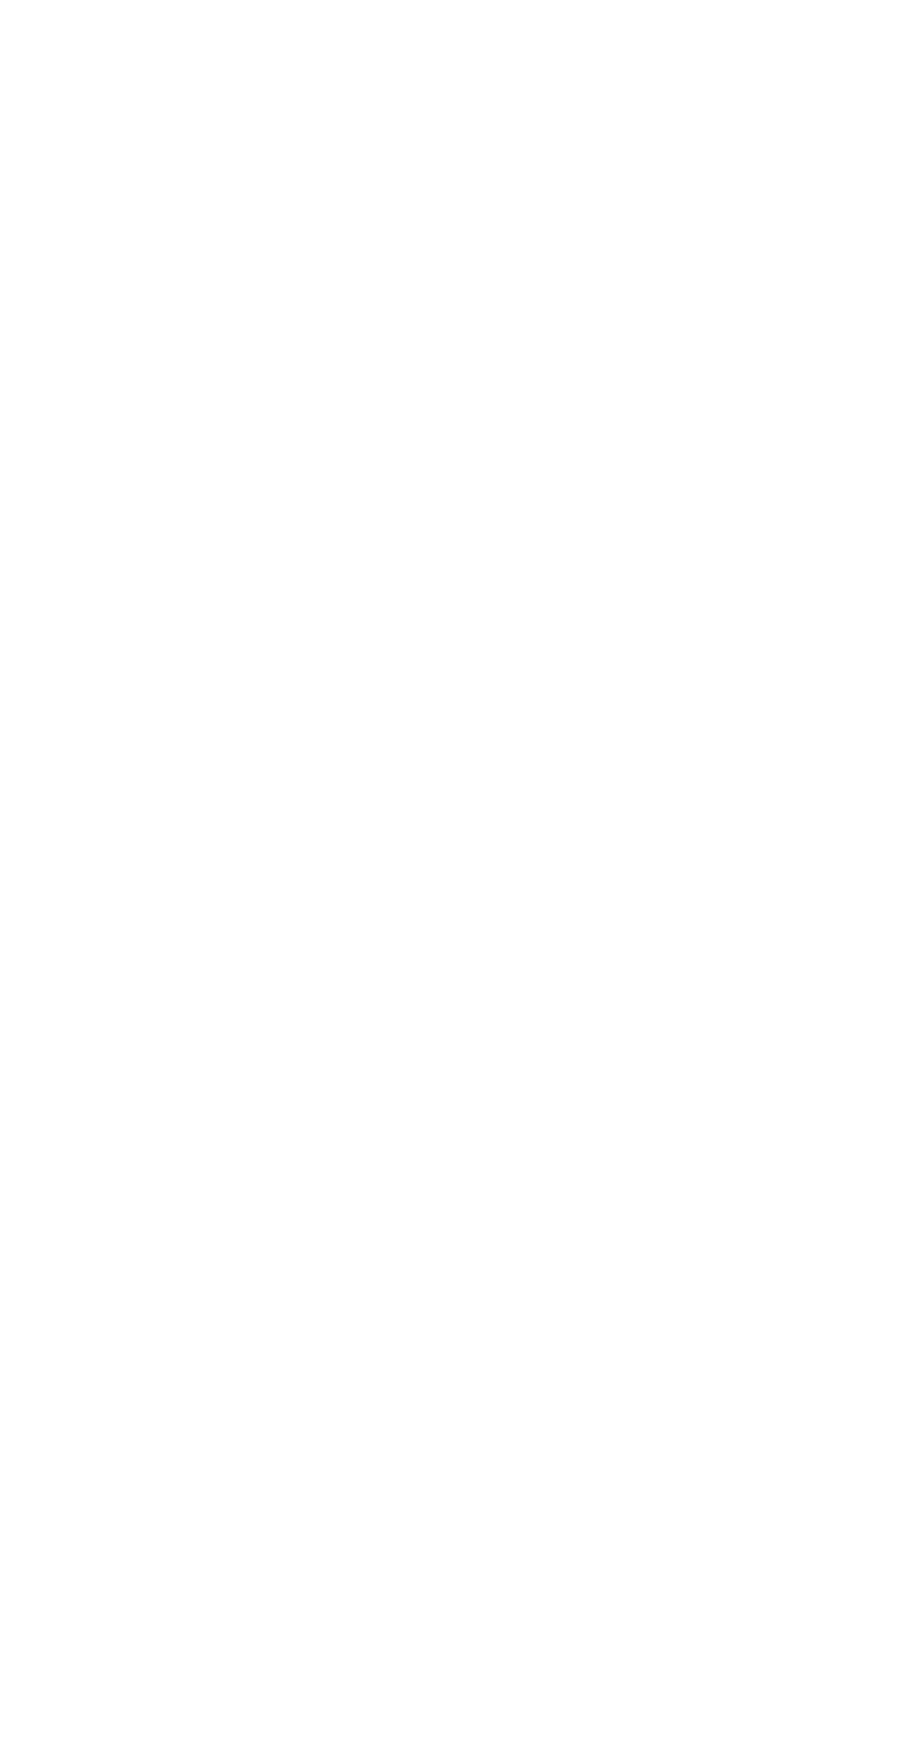

In [12]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]
next_human_pix = [os.path.join(train_human_dir, fname) 
                for fname in train_human_fnames[ pic_index-8:pic_index]
               ]
next_other_pix = [os.path.join(train_other_dir, fname) 
                for fname in train_other_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix+next_human_pix+next_other_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  #plt.imshow(img)

plt.show()


It may not be obvious from looking at the images in this grid, but an important note here, and a significant difference from the previous lesson is that these images come in all shapes and sizes. When you did the handwriting recognition example, you had 28x28 greyscale images to work with. These are color and in a variety of shapes. Before training a Neural network with them you'll need to tweak the images. You'll see that in the next section.

Ok, now that you have an idea for what your data looks like, the next step is to define the model that will be trained to recognize cats or dogs from these images 

Next we will define a Sequential layer as before, adding some convolutional layers first. Note the input shape parameter this time. In the earlier example it was 28x28x1, because the image was 28x28 in greyscale (8 bits, 1 byte for color depth). This time it is 150x150 for the size and 3 (24 bits, 3 bytes) for the color depth. 


## Building a Small Model from Scratch to Get to ~72% Accuracy

In the previous section you saw that the images were in a variety of shapes and sizes. In order to train a neural network to handle them you'll need them to be in a uniform size. We've chosen 150x150 for this, and you'll see the code that preprocesses the images to that shape shortly. 

But before we continue, let's start defining the model:

Step 1 will be to import tensorflow.

We then add a couple of convolutional layers as in the previous example, and flatten the final result to feed into the densely connected layers.

Finally we add the densely connected layers. 

Note that because we are facing a multi-class classification problem, we will end our network with a [*softmax* activation](https://wikipedia.org/wiki/Softmax_function), so that the output of our network will be a single scalar between 0 and 4.

In [30]:

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rotation_range=50,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='constant',
                                    cval=0,
                                    rescale=1./255,
                                  )
valid_datagen  = ImageDataGenerator( rescale = 1.0/255
                                  )
predict_datagen  = ImageDataGenerator( rescale = 1.0/255
                                  )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# -------------------- 
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    shuffle='True',
                                                    class_mode='categorical', 
                                                    target_size=(150, 150)) 
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  valid_datagen.flow_from_directory(validation_dir,
                                                         target_size = (150, 150),
                                                         batch_size=32,
                                                         class_mode='categorical',
                                                         shuffle='False',
                                                         )
predict_generator=predict_datagen.flow_from_directory(predict_dir,
                                                target_size=(150,150),
                                                class_mode=None,
                                                batch_size=3)


Found 5103 images belonging to 4 classes.
Found 2137 images belonging to 4 classes.
Found 0 images belonging to 0 classes.


In [31]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = 'C:/Users/sethr/education/Healthcare/imagedetect/modelimageadvance/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = local_weights_file)

#pre_trained_model.load_weights(local_weights_file)
#print (local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False 
  
# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output
pre_trained_model.summary()
#for layer in pre_trained_model.layers: print(layer.get_config(), layer.get_weights())

last layer output shape:  (None, 7, 7, 768)
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
___________________________________________

The "output shape" column shows how the size of your feature map evolves in each successive layer. The convolution layers reduce the size of the feature maps by a bit due to padding, and each pooling layer halves the dimensions.

Next, we'll configure the specifications for model training. We will train our model with the `sparse categorical_crossentropy` loss, because it's a binary classification problem and our final activation is a sigmoid. (For a refresher on loss metrics, see the [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/descending-into-ml/video-lecture).) We will use the `rmsprop` optimizer with a learning rate of `0.001`. During training, we will want to monitor classification accuracy.

**NOTE**: In this case, using the [ADAM optimization algorithm]( [Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam) and [Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad), also automatically adapt the learning rate during training, and would work equally well here.)

In [13]:
from tensorflow.keras.optimizers import Adam

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)

# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.35
x = layers.Dropout(0.35)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (4, activation='softmax')(x)           

model = Model( pre_trained_model.input, x) 

optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'
    )

model.compile(optimizer,
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

### Data Preprocessing

Let's set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images. Our generators will yield batches of 20 images of size 150x150 and their labels (binary).

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).

In Keras this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows you to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. These generators can then be used with the Keras model methods that accept data generators as inputs: `fit`, `evaluate_generator`, and `predict_generator`.

### Training
Let's train on all 2,000 images available, for 15 epochs, and validate on all 1,000 test images. (This may take a few minutes to run.)

Do note the values per epoch.

You'll see 4 values per epoch -- Loss, Accuracy, Validation Loss and Validation Accuracy. 

The Loss and Accuracy are a great indication of progress of training. It's making a guess as to the classification of the training data, and then measuring it against the known label, calculating the result. Accuracy is the portion of correct guesses. The Validation accuracy is the measurement with the data that has not been used in training. As expected this would be a bit lower. You'll learn about why this occurs in the section on overfitting later in this course.


In [14]:
model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch =100,
            epochs = 50,
            validation_steps = 20,
            verbose = 2)
model.save('C:/Users/sethr/education/Healthcare/imagedetect/modelimageadvance')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 20 steps
Epoch 1/50
100/100 - 196s - loss: 1.1650 - accuracy: 0.6726 - val_loss: 0.5749 - val_accuracy: 0.8313
Epoch 2/50
100/100 - 159s - loss: 0.6326 - accuracy: 0.7637 - val_loss: 0.4526 - val_accuracy: 0.8516
Epoch 3/50
100/100 - 183s - loss: 0.5563 - accuracy: 0.7906 - val_loss: 0.4286 - val_accuracy: 0.8672
Epoch 4/50
100/100 - 185s - loss: 0.5431 - accuracy: 0.8019 - val_loss: 0.5303 - val_accuracy: 0.8391
Epoch 5/50
100/100 - 180s - loss: 0.5057 - accuracy: 0.8062 - val_loss: 0.4479 - val_accuracy: 0.8562
Epoch 6/50
100/100 - 175s - loss: 0.5077 - accuracy: 0.7997 - val_loss: 0.4963 - val_accuracy: 0.8781
Epoch 7/50
100/100 - 171s - loss: 0.4823 - accuracy: 0.8231 - val_loss: 0.4240 - val_accuracy: 0.8844
Epoch 8/50
100/100 - 170s - loss: 0.4967 - accuracy: 0.8072 - val_loss: 0.4213 - val_accuracy: 0.8687
Epoch 9/50
100/100 - 166s - loss: 0.4937 - accuracy: 0.8100 - val_loss: 0.5034 - val_accura

In [3]:
from tensorflow import keras
model = keras.models.load_model('C:/Users/sethr/education/Healthcare/imagedetect/modelimageadvance')
#model.summary()

In [13]:
import numpy as np
import cv2
import glob
from keras.preprocessing import image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

labels= ["cat","dog","human","other"]
path='C:/Users/sethr/education/Healthcare/imagedetect/predict/*.jpg'
for fim in glob.glob(path):
  # predicting images
  img=image.load_img(fim,target_size=(150, 150))
  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  plt.figure()
 # plt.imshow(img)
  plt.show()
  classes = model.predict(images, batch_size=10)
  #classes=train_cnnimage(images,batchsize=10)
  print(classes[0])
  print (labels[np.argmax(classes)])  

<Figure size 432x288 with 0 Axes>

[0.000000e+00 0.000000e+00 6.607166e-19 1.000000e+00]
other


<Figure size 432x288 with 0 Axes>

[0.0000000e+00 0.0000000e+00 1.0625962e-14 1.0000000e+00]
other


<Figure size 432x288 with 0 Axes>

[0. 0. 0. 1.]
other


<Figure size 432x288 with 0 Axes>

[0.000000e+00 0.000000e+00 1.000000e+00 7.645067e-24]
human


<Figure size 432x288 with 0 Axes>

[0.0000000e+00 0.0000000e+00 2.0431537e-19 1.0000000e+00]
other


<Figure size 432x288 with 0 Axes>

[0. 0. 0. 1.]
other


<Figure size 432x288 with 0 Axes>

[0.0000000e+00 0.0000000e+00 1.6428182e-32 1.0000000e+00]
other


<Figure size 432x288 with 0 Axes>

[0.0000000e+00 0.0000000e+00 1.4795569e-15 1.0000000e+00]
other


<Figure size 432x288 with 0 Axes>

[0.0000000e+00 0.0000000e+00 1.3515186e-20 1.0000000e+00]
other


<Figure size 432x288 with 0 Axes>

[0.000000e+00 0.000000e+00 1.936543e-14 1.000000e+00]
other


<Figure size 432x288 with 0 Axes>

[0.0000000e+00 0.0000000e+00 1.0237066e-07 9.9999988e-01]
other


<Figure size 432x288 with 0 Axes>

[0. 0. 0. 1.]
other


<Figure size 432x288 with 0 Axes>

[0.0000000e+00 0.0000000e+00 8.2922376e-12 1.0000000e+00]
other


<Figure size 432x288 with 0 Axes>

[0.0000000e+00 0.0000000e+00 9.9970335e-01 2.9659888e-04]
human


<Figure size 432x288 with 0 Axes>

[0.0000000e+00 0.0000000e+00 1.1658688e-35 1.0000000e+00]
other


<Figure size 432x288 with 0 Axes>

[0. 0. 0. 1.]
other


<Figure size 432x288 with 0 Axes>

[0. 0. 1. 0.]
human


<Figure size 432x288 with 0 Axes>

[0.000000e+00 0.000000e+00 8.185717e-29 1.000000e+00]
other


<Figure size 432x288 with 0 Axes>

[0.0000000e+00 0.0000000e+00 1.0000000e+00 1.2466262e-13]
human


<Figure size 432x288 with 0 Axes>

[0. 0. 0. 1.]
other


<Figure size 432x288 with 0 Axes>

[0. 0. 0. 1.]
other


<Figure size 432x288 with 0 Axes>

[0.0000000e+00 0.0000000e+00 1.0000000e+00 2.3558015e-21]
human


<Figure size 432x288 with 0 Axes>

[0. 0. 1. 0.]
human


<Figure size 432x288 with 0 Axes>

[0.0000000e+00 0.0000000e+00 1.3820838e-09 1.0000000e+00]
other


<Figure size 432x288 with 0 Axes>

[0.000000e+00 0.000000e+00 1.000000e+00 4.909375e-11]
human


<Figure size 432x288 with 0 Axes>

[0.000000e+00 0.000000e+00 9.999999e-01 6.262378e-08]
human


<Figure size 432x288 with 0 Axes>

[0.000000e+00 0.000000e+00 1.995782e-08 1.000000e+00]
other


<Figure size 432x288 with 0 Axes>

[0.0000000e+00 0.0000000e+00 3.6884835e-12 1.0000000e+00]
other


<Figure size 432x288 with 0 Axes>

[0.0000000e+00 0.0000000e+00 1.6950466e-37 1.0000000e+00]
other


<Figure size 432x288 with 0 Axes>

[0.0000000e+00 0.0000000e+00 5.2789397e-18 1.0000000e+00]
other


<Figure size 432x288 with 0 Axes>

[0. 0. 0. 1.]
other


<Figure size 432x288 with 0 Axes>

[0.00000000e+00 0.00000000e+00 1.02334935e-26 1.00000000e+00]
other


<Figure size 432x288 with 0 Axes>

[0.0000000e+00 0.0000000e+00 9.9999094e-01 9.0299045e-06]
human


<Figure size 432x288 with 0 Axes>

[0.0000000e+00 0.0000000e+00 1.0000000e+00 5.0888325e-15]
human


<Figure size 432x288 with 0 Axes>

[0. 0. 1. 0.]
human


<Figure size 432x288 with 0 Axes>

[0.000000e+00 0.000000e+00 1.000000e+00 8.392333e-09]
human


<Figure size 432x288 with 0 Axes>

[0.000000e+00 0.000000e+00 4.819288e-26 1.000000e+00]
other


<Figure size 432x288 with 0 Axes>

[0. 0. 0. 1.]
other


<Figure size 432x288 with 0 Axes>

[0.000000e+00 0.000000e+00 1.000000e+00 7.740888e-30]
human


<Figure size 432x288 with 0 Axes>

[0.0000000e+00 0.0000000e+00 2.4023228e-19 1.0000000e+00]
other


<Figure size 432x288 with 0 Axes>

[0.0000000e+00 0.0000000e+00 2.3796708e-38 1.0000000e+00]
other


<Figure size 432x288 with 0 Axes>

[0. 0. 0. 1.]
other


<Figure size 432x288 with 0 Axes>

[0.0000000e+00 0.0000000e+00 1.0000000e+00 4.1906805e-19]
human


<Figure size 432x288 with 0 Axes>

[0.         0.         0.00215065 0.99784935]
other


<Figure size 432x288 with 0 Axes>

[0.000000e+00 0.000000e+00 1.000000e+00 1.766754e-25]
human


<Figure size 432x288 with 0 Axes>

[0. 0. 0. 1.]
other


<Figure size 432x288 with 0 Axes>

[0. 0. 1. 0.]
human


<Figure size 432x288 with 0 Axes>

[0. 0. 1. 0.]
human


<Figure size 432x288 with 0 Axes>

[0.0000000e+00 0.0000000e+00 3.8048693e-21 1.0000000e+00]
other


<Figure size 432x288 with 0 Axes>

[0. 0. 0. 1.]
other


<Figure size 432x288 with 0 Axes>

[0. 0. 0. 1.]
other


<Figure size 432x288 with 0 Axes>

[0.0000000e+00 0.0000000e+00 1.0000000e+00 5.8720954e-35]
human


<Figure size 432x288 with 0 Axes>

[0.0000000e+00 0.0000000e+00 7.4676973e-06 9.9999249e-01]
other


<Figure size 432x288 with 0 Axes>

[0. 0. 0. 1.]
other


<Figure size 432x288 with 0 Axes>

[0. 0. 0. 1.]
other


<Figure size 432x288 with 0 Axes>

[0. 0. 0. 1.]
other


<Figure size 432x288 with 0 Axes>

[0. 0. 0. 1.]
other


<Figure size 432x288 with 0 Axes>

[0.000000e+00 0.000000e+00 9.994330e-01 5.669424e-04]
human


<Figure size 432x288 with 0 Axes>

[0.00000000e+00 0.00000000e+00 1.00000000e+00 1.22241576e-14]
human


<Figure size 432x288 with 0 Axes>

[0.0000000e+00 0.0000000e+00 2.6246139e-18 1.0000000e+00]
other


<Figure size 432x288 with 0 Axes>

[0.0000000e+00 0.0000000e+00 1.3864510e-06 9.9999857e-01]
other


<Figure size 432x288 with 0 Axes>

[0. 0. 0. 1.]
other


<Figure size 432x288 with 0 Axes>

[0.0000000e+00 0.0000000e+00 6.6953965e-07 9.9999928e-01]
other


<Figure size 432x288 with 0 Axes>

[0.000000e+00 0.000000e+00 1.000000e+00 7.224388e-23]
human


<Figure size 432x288 with 0 Axes>

[0. 0. 1. 0.]
human


<Figure size 432x288 with 0 Axes>

[0. 0. 0. 1.]
other


<Figure size 432x288 with 0 Axes>

[0.000000e+00 0.000000e+00 1.000000e+00 4.599887e-37]
human


<Figure size 432x288 with 0 Axes>

[0.         0.         0.01382883 0.9861712 ]
other


<Figure size 432x288 with 0 Axes>

[0.00000000e+00 0.00000000e+00 1.00000000e+00 1.11601616e-35]
human


### Visualizing Intermediate Representations

To get a feel for what kind of features our convnet has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the convnet.

Let's pick a random cat or dog image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.

C:\Users\sethr\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


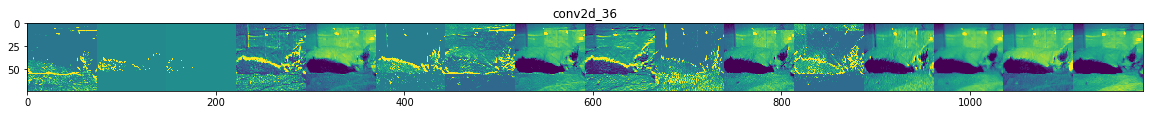

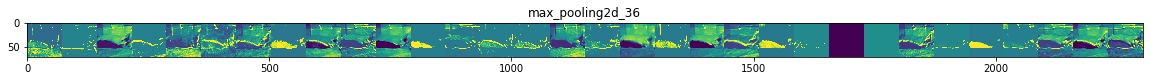

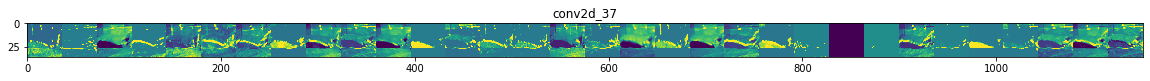

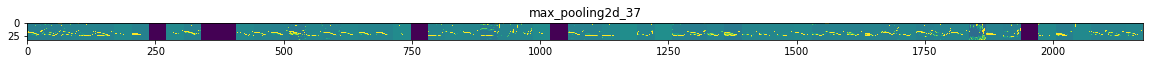

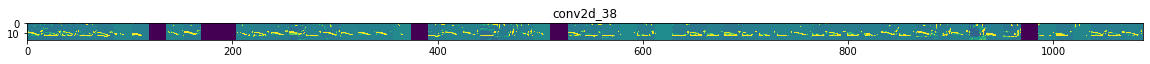

In [129]:
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]

img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

As you can see we go from the raw pixels of the images to increasingly abstract and compact representations. The representations downstream start highlighting what the network pays attention to, and they show fewer and fewer features being "activated"; most are set to zero. This is called "sparsity." Representation sparsity is a key feature of deep learning.


These representations carry increasingly less information about the original pixels of the image, but increasingly refined information about the class of the image. You can think of a convnet (or a deep network in general) as an information distillation pipeline.

### Evaluating Accuracy and Loss for the Model

Let's plot the training/validation accuracy and loss as collected during training:

In [132]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

NameError: name 'history' is not defined

As you can see, we are **overfitting** like it's getting out of fashion. Our training accuracy (in blue) gets close to 100% (!) while our validation accuracy (in green) stalls as 70%. Our validation loss reaches its minimum after only five epochs.

Since we have a relatively small number of training examples (2000), overfitting should be our number one concern. Overfitting happens when a model exposed to too few examples learns patterns that do not generalize to new data, i.e. when the model starts using irrelevant features for making predictions. For instance, if you, as a human, only see three images of people who are lumberjacks, and three images of people who are sailors, and among them the only person wearing a cap is a lumberjack, you might start thinking that wearing a cap is a sign of being a lumberjack as opposed to a sailor. You would then make a pretty lousy lumberjack/sailor classifier.

Overfitting is the central problem in machine learning: given that we are fitting the parameters of our model to a given dataset, how can we make sure that the representations learned by the model will be applicable to data never seen before? How do we avoid learning things that are specific to the training data?

In the next exercise, we'll look at ways to prevent overfitting in the cat vs. dog classification model.

## Clean Up

Before running the next exercise, run the following cell to terminate the kernel and free memory resources:

In [0]:
import os, signal

os.kill(     os.getpid() , 
         signal.SIGKILL
       )